# Chapter 1.  Introduction

In [20]:
options(warn=-1)
library(glmnet)
library(Metrics)
library(repr)
set.seed(1)

## Polynomial Curve Fitting

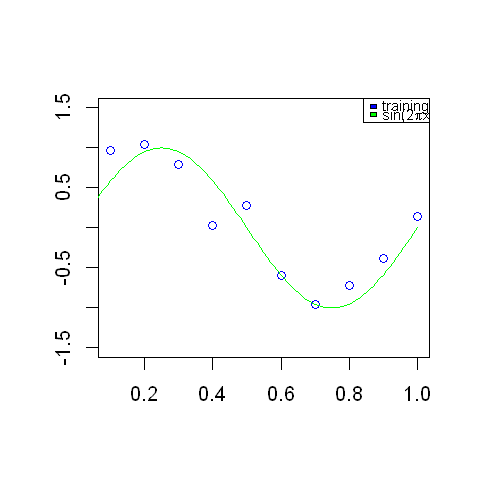

In [21]:
func <- function(x){
        y <- sin(2*pi*x)
        return(y)
}

generate_data <- function(func,sample_size,std){
        x <- seq(0, 1, length.out = (sample_size+1))[-1]
        t <- func(x)+rnorm(sample_size,mean = 0, sd = std)
        result <- list("predictor_X"=x, "responser_t"=t)
        return(result)
}

x_train <- generate_data(func, 10, 0.25)$predictor_X
y_train <- generate_data(func, 10, 0.25)$responser_t
x_test <- seq(0, 1, length.out = (101))[-1]
y_test = func(x_test)

# library(repr)

# Change plot size to 4 x 3
#options(repr.plot.width=5,repr.plot.height=4)
options(repr.plot.width=4,repr.plot.height=4)
plot(x_train, y_train,
     type="p",
     col="blue", xlab="", ylab="",
     ylim = c(-1.5,1.5))
lines(x_test,y_test, col="green")
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)"))),
       fill=c("blue","green"), cex =0.75
)


# Change plot size to 4 x 3


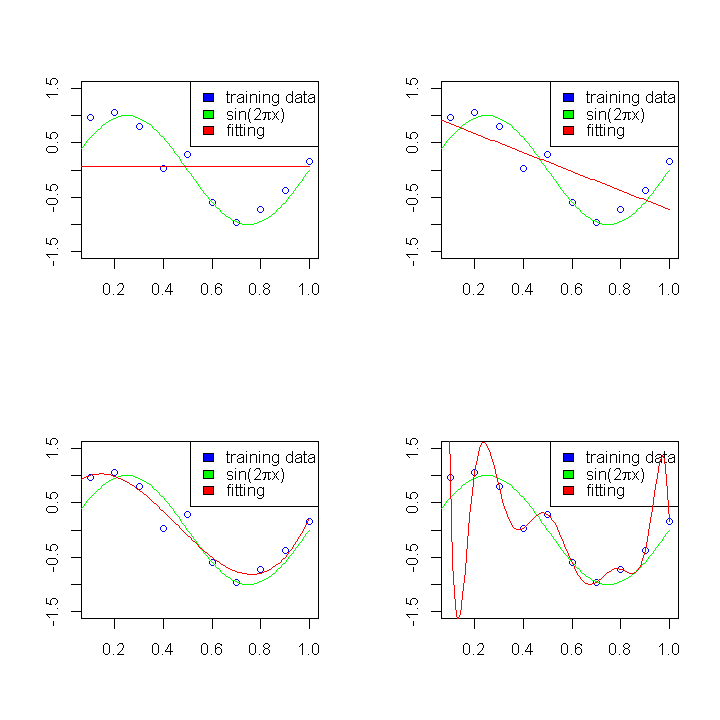

In [25]:

par(mfrow=c(2,2))
df <- data.frame(p = x_train, r = y_train)

model <- lm(r ~ 1,, data=df)
y_pred <- predict(model, newdata =  data.frame(p = x_test))

options(repr.plot.width=6,repr.plot.height=6)
plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", ylim = c(-1.5,1.5))
lines(x_test,y_test, col="green")
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting"),
       fill=c("blue","green","red"))
lines(x_test,y_pred, col="red")



drgree <- c(1,3,9)
for(i in drgree){
        drgree = 3
        model <- lm(r ~ poly(p, i), data=df)
        y_pred <- predict(model, newdata =  data.frame(p = x_test))
        plot(x_train, y_train,
             type="p", col="blue", xlab="", ylab="", ylim = c(-1.5,1.5))
        lines(x_test,y_test, col="green")
        legend("topright",
               c("training data",expression(paste("sin(2", pi, "x)")),"fitting"),
               fill=c("blue","green","red"))
        lines(x_test,y_pred, col="red")
        
        
}


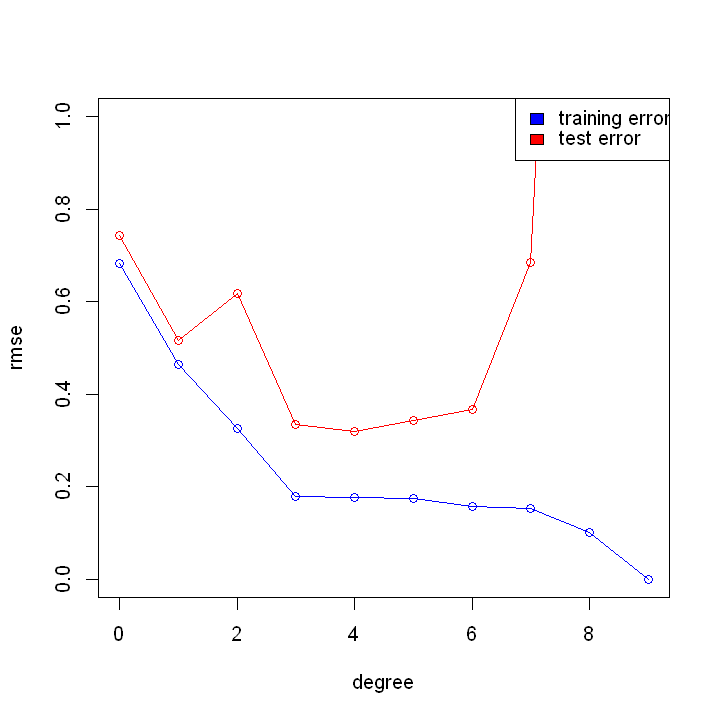

In [26]:
y_true = func(x_test) + rnorm(length(x_test), mean = 0, sd = 0.25)
training_errors <- c()
test_errors <- c()

model <- lm(r ~ 1, data=df)
y_pred <- predict(model)
training_errors <- c(training_errors, rmse(y_pred, y_train))

y_pred <- predict(model, newdata =  data.frame(p = x_test))
test_errors <- c(test_errors, rmse(y_pred, y_true))

for (i in 1:9){
        model <- lm(r ~ poly(p, i), data=df)
        y_pred <- predict(model)
        training_errors <- c(training_errors, rmse(y_pred, y_train))
        
        y_pred <- predict(model, newdata =  data.frame(p = x_test))
        test_errors <- c(test_errors, rmse(y_pred, y_true))
}

par(mfrow=c(1,1))
M <- seq(0, 9, by=1)

plot(M, training_errors,
     type="o",col="blue", xlab="degree", ylab="rmse", ylim = c(0,1))

lines(M, test_errors, type="o",col="red")

legend("topright",
       c("training error","test error"),
       fill=c("blue","red")
)



## Regularization

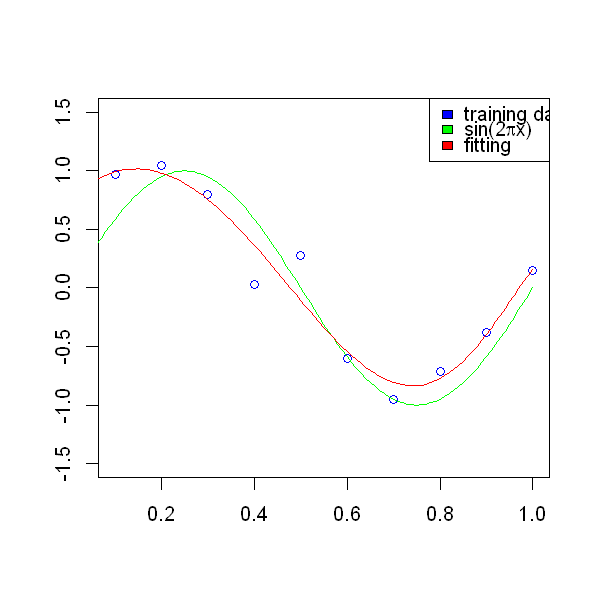

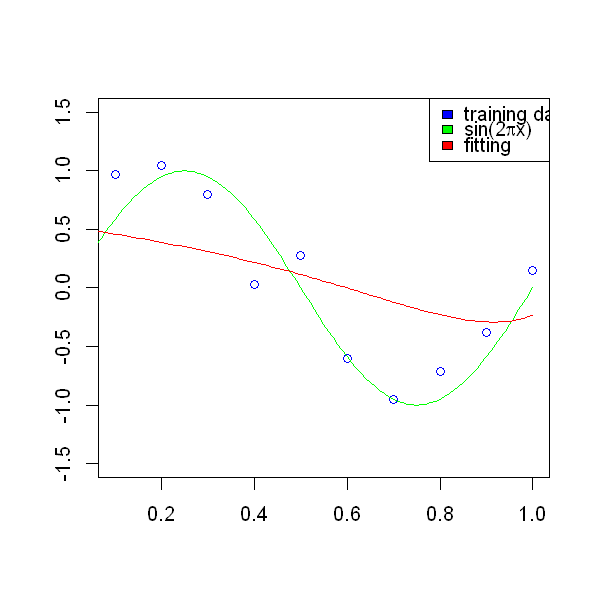

In [40]:
Xmat <- cbind(df$p, df$p^2, df$p^3, df$p^4, df$p^5, 
              df$p^6, df$p^7, df$p^8, df$p^9)
colnames(Xmat) <- c('x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9')

x_test_mat <- cbind(x_test, x_test^2, x_test^3, x_test^4, x_test^5, 
              x_test^6, x_test^7, x_test^8, x_test^9)
colnames(x_test_mat) <- c('x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9')

options(repr.plot.width=5,repr.plot.height=5)
# ln(lambda) = -18
ridge_models <- glmnet(Xmat, df$r, alpha=0, lambda=exp(-18))
test_pred_ridge <- predict(ridge_models,  x_test_mat)
plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", ylim = c(-1.5,1.5))
lines(x_test,y_test, col="green")
lines(x_test,test_pred_ridge, col="red")
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting"),
       fill=c("blue","green","red"))

# ln(lambda) = 0
ridge_models <- glmnet(Xmat, df$r, alpha=0, lambda=exp(0))
test_pred_ridge <- predict(ridge_models,  x_test_mat)
plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", ylim = c(-1.5,1.5))
lines(x_test,y_test, col="green")
lines(x_test,test_pred_ridge, col="red")
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting"),
       fill=c("blue","green","red"))



## Bayesian curve fitting

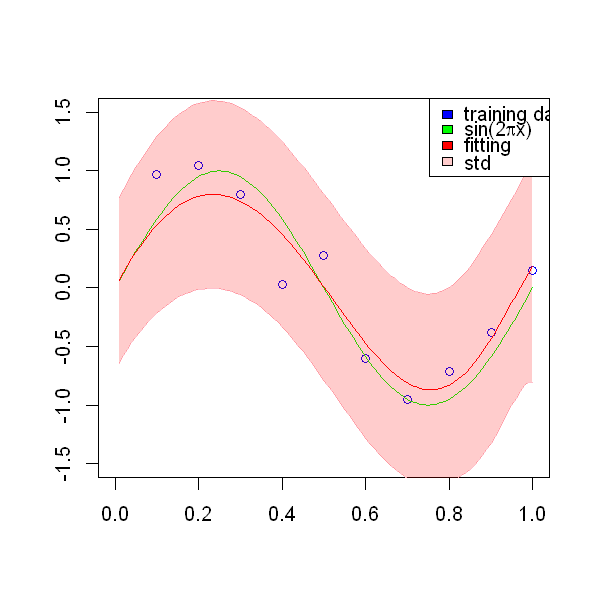

In [41]:
####### Bayesian curve fitting ###################################
w_mean = NA
w_precision = NA


is_prior_defined <- function(A,B) {
        return(!is.na(A) & !is.na(B))
}



get_prior <- function(w_mean,w_precision, ndim, alpha) {
        if (is_prior_defined(w_mean,w_precision)){
                return(c(w_mean,w_precision))
        } else {
                a = rep(0, ndim)
                b = alpha * diag(ndim)
                result <- list("mean"=a, "precision"=b)
                return(result)
        }
        
}

BayesianReg_fit <- function(w_mean,w_precision,ndim=ncol(X), alpha, beta, X, t){
        mean_prev = get_prior(w_mean,w_precision, ndim, alpha)$mean
        precision_prev = get_prior(w_mean,w_precision,ndim, alpha)$precision
        
        w_precision = precision_prev + beta * t(X) %*% X
        w_mean = solve(w_precision,
                       precision_prev %*% as.matrix(mean_prev) + beta * t(X) %*% t)
        
        w_cov = solve(w_precision)
        result <- list("w_mean"=w_mean, "w_precision"=w_precision, "w_cov"=w_cov)
        return(result)
}

BayesianReg_predict <- function(X, w_mean, w_cov, beta){
        y = X %*% w_mean
        y_var = 1 / beta + rowSums(X %*% w_cov * X)
        y_std = sqrt(y_var)
        result <- list("y.pred"=y, "y.std"=y_std)
        return(result)
}


fit_result <- BayesianReg_fit(w_mean,w_precision,ndim=ncol(Xmat), alpha=2e-3, beta=2,X = Xmat, t = y_train)
fit.mean <- fit_result$w_mean
fit.precision <- fit_result$w_precision
fit.cov <- fit_result$w_cov



pred_result <- BayesianReg_predict(x_test_mat, fit.mean, fit.cov, beta=2)
y <- pred_result$y.pred
y_err <- pred_result$y.std



plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", xlim = c(0,1), ylim = c(-1.5,1.5))
lines(x_test,y_test, col="green")
lines(x_test,y, col="red")
lines(x_test,y - y_err, col="pink")
lines(x_test,y + y_err, col="pink")
x=x_test
y1 = y - y_err
y2 = y + y_err
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","green","red",rgb(1, 0, 0,0.2)))